In [1]:
%pylab inline
import random
import numpy as np
from scipy.optimize import minimize


Populating the interactive namespace from numpy and matplotlib


In [28]:
###########
# In simulations below:
# G = num genes
# T = % target genes
# L = lambda* (non-null pvals follow exponential (lambda=lambda*))
###########

############### Simulation functions #################
# Simulate pvals for given T, Lambda*
def SimulatePvals(G, T, L):
    # Simulate log pvalues
    pvals = []
    for i in range(G):
        if random.random() < T:
            pvals.append(np.random.exponential(L))
        else:
            pvals.append(np.random.exponential(1))
    return pvals
######################################################

############### Likelihood functions #################
def LogLikelihood(pvals, T, L):
    """
    Compute likelihood of log pvals, given T=% non-null, and L=lambda for non-null
    """
    loglik = 0
    for p in pvals:
        loglik += np.log(GetProb(p, T, L))
    return loglik

def ExpProb(p, L):
    """
    Helper function for likelihood
    Return pdf from exponential
    """
    return 1/L*np.exp(-p*1/L)
    
def GetProb(p, T, L):
    """
    Helper function for likelihood
    Compute probablity of p for a given T and L
    """
    return T*ExpProb(p, L) + (1-T)*ExpProb(p, 1)
######################################################

############### Plotting functions ###################
def QQPlot(pvals, title=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    null = np.random.exponential(1, size=G)
    ax.scatter(sorted(null), sorted(pvals))
    ax.plot([0, max(null)], [0, max(null)])
    ax.set_xlabel("Expected log p")
    ax.set_ylabel("Observed log p");
    if title is not None: ax.set_title(title)
    

def LikPlot(Tvals, LogLiks, T, title=None):
    """
    Plot T vs. log likelihood
    """
    maxLik = Tvals[LogLiks.index(max(LogLiks))]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(Tvals, LogLiks, color="black", label="LogLik")
    ax.axvline(x=T, color="black", linestyle="dashed", label="True T")
    ax.axvline(x=maxLik, color="red", linestyle="dashed", label="Max. Likelihood T")
    ax.set_xlabel("T (% non-null)")
    ax.set_ylabel("log lik")
    ax.legend()
    if title is not None: ax.set_title(title)
######################################################

In [32]:
# Could we even get both T and L if both are unknown?
# Idea, kind of like an EM algorithm: 
#  Guess L
#  Find best T holding L constant
#  Find best L holding T constant
#  Repeat until convergence
# Alternatively, we can just earch over L,T exhaustively

############### Optimization/EM functions ###################

# Naive functions to find best T, L by testing range of values
#def FindBestT(pvals, L):
#    Tvals = np.arange(0, 1, 0.01)
#    LogLiks = [LogLikelihood(pvals, t, L) for t in Tvals] # exhaustive search. could speed this up
#    maxLikT = Tvals[LogLiks.index(max(LogLiks))]
#    return maxLikT, max(LogLiks)

#def FindBestL(pvals, T):
#    Lvals = np.arange(1, 3, 0.1)
#    LogLiks = [LogLikelihood(pvals, T, l) for l in Lvals] # exhaustive search. could speed this up
#    maxLikL = Lvals[LogLiks.index(max(LogLiks))]
#    return maxLikL, max(LogLiks)

# Better functions to find best T, L by using scipy.optimize.minimize
def NegLogLikT(L, pvals):
    def likfunc(t):
        return -1*LogLikelihood(pvals, t, L)
    return likfunc

def NegLogLikL(T, pvals):
    def likfunc(l):
        return -1*LogLikelihood(pvals, T, l)
    return likfunc

def FindBestT(pvals, L, initialGuessT=0.0):
    res = minimize(NegLogLikT(L, pvals), np.array([initialGuessT]), bounds=[(0, 1)])
    maxLikT = res.x[0] # best T from the optimizer
    LogLik = LogLikelihood(pvals, maxLikT, L) # likelihood of the best T
    return maxLikT, LogLik

def FindBestL(pvals, T, initialGuessL=1.0):
    res = minimize(NegLogLikL(T, pvals), np.array([initialGuessL]), bounds=[(1, 5)])
    maxLikL = res.x[0] # best T from the optimizer
    LogLik = LogLikelihood(pvals, T, maxLikL) # likelihood of the best T
    return maxLikL, LogLik
                                    

def FindBestTL(pvals, epsilon=0.1, maxiter=10):
    # Guess L
    guessL = 2.5
    guessT, maxlik = FindBestT(pvals, guessL)
    iternum = 1
    while True:
        print("GuessL=%s GuessT=%s Lik=%s"%(guessL, guessT, maxlik))
        # Find best L, holding T constant
        guessL, newlik = FindBestL(pvals, guessT)
        # Find best T, holding L constant
        guessT, newlik = FindBestT(pvals, guessL)
        # If we've converged, we're done
        if abs(newlik-maxlik)<epsilon:
            break
        # Give up at some point
        if iternum >= maxiter:
            guessL = float("nan")
            guessT = float("nan")
            break
        maxlik = newlik
        iternum += 1
    return guessL, guessT
######################################################

trueL=1.1; trueT=0.01; estT=0.0009440388202059138
trueL=1.1; trueT=0.05; estT=0.04281778917272925
trueL=1.1; trueT=0.1; estT=0.08186814507636542
trueL=1.1; trueT=0.25; estT=0.30789392715531994
trueL=1.5; trueT=0.01; estT=0.018339180688695087
trueL=1.5; trueT=0.05; estT=0.047547794792826246
trueL=1.5; trueT=0.1; estT=0.07994008707722479
trueL=1.5; trueT=0.25; estT=0.2602807047317803
trueL=2; trueT=0.01; estT=0.01406847832715997
trueL=2; trueT=0.05; estT=0.045659599895038795
trueL=2; trueT=0.1; estT=0.10415561031226464
trueL=2; trueT=0.25; estT=0.25949462990096844


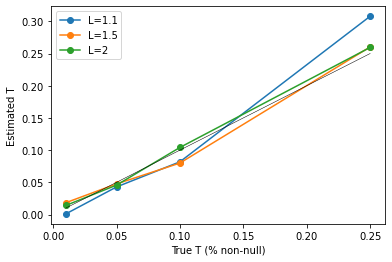

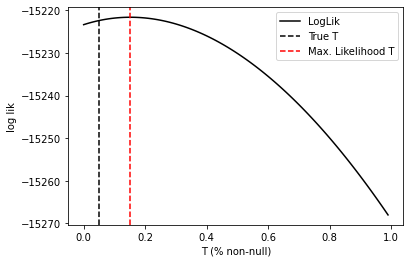

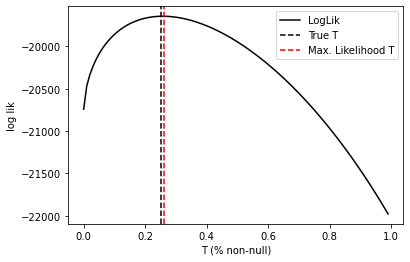

In [37]:
######################################################
# First, can we get it right if we assume we know L?
######################################################

Tvals = np.arange(0, 1, 0.01) # Tvals to consider when searching for best
G = 15000 # number of genes

fig = plt.figure()
ax = fig.add_subplot(111)

trueTvals = [0.01, 0.05, 0.1, 0.25]
for trueL in [1.1,  1.5, 2]:
    estTvals  = []
    for trueT in trueTvals:
        pvals = SimulatePvals(G, trueT, trueL)
        bestT, newlik = FindBestT(pvals, trueL)
        estTvals.append(bestT)
        title="trueL=%s; trueT=%s; estT=%s"%(trueL, trueT, bestT)
        print(title)
    ax.plot(trueTvals, estTvals, label="L=%s"%trueL, marker="o")
ax.set_xlabel("True T (% non-null)")
ax.set_ylabel("Estimated T")
ax.plot(trueTvals, trueTvals, color="black", linewidth=0.5)
ax.legend()

# Plot likelihood profile of a hard case
# Likelihood surface not very pointy - 
# best guess is not that much better than other possible values for T
# probably won't have a strong p-values
T=0.05
L=1.1
pvals = SimulatePvals(G, T, L)
LikPlot(Tvals, [LogLikelihood(pvals, t, L) for t in Tvals], T, title=None)

# Plot likelihood profile of an esier case
# Likelihood surface more pointy, guess more precise
T=0.25
L=2.5
pvals = SimulatePvals(G, T, L)
LikPlot(Tvals, [LogLikelihood(pvals, t, L) for t in Tvals], T, title=None)

GuessL=2.5 GuessT=0.004480961113610198 Lik=-15299.871178249048
GuessL=2.063494861099833 GuessT=0.010089172904324685 Lik=-15299.20860397694
GuessL=1.8213729516437573 GuessT=0.016369986437068634 Lik=-15298.737591434383
GuessL=1.670094100825724 GuessT=0.02270043096231074 Lik=-15298.430481861453
GuessL=1.569436815367562 GuessT=0.02872142663718647 Lik=-15298.23400186502
GuessL=1.4977512930202883 GuessT=0.03441064840968862 Lik=-15298.103473099194
#########################
trueL=1.1; estL=1.4447555564190802; trueT=0.01; estT=0.039715814026797344
GuessL=2.5 GuessT=0.0023627536277602 Lik=-15270.601966404554
GuessL=1.9995580618180229 GuessT=0.007255081688111044 Lik=-15270.178991629205
GuessL=1.7344367471187 GuessT=0.013664821897366385 Lik=-15269.816773674173
GuessL=1.5700503840487332 GuessT=0.02105649451344323 Lik=-15269.540131388989
GuessL=1.4609820306211772 GuessT=0.028985697532632096 Lik=-15269.337227043245
GuessL=1.3845317332229672 GuessT=0.03721846934626678 Lik=-15269.187391328018
GuessL=1.

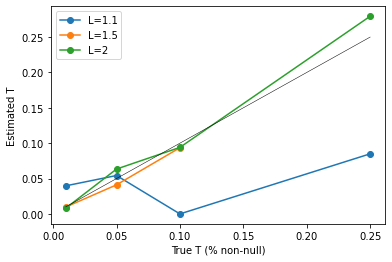

In [38]:
######################################################
# Now, can we get it right if we don't know either T or L?
######################################################


Tvals = np.arange(0, 1, 0.01) # Tvals to consider when searching for best
G = 15000 # number of genes

fig = plt.figure()
ax = fig.add_subplot(111)

trueTvals = [0.01, 0.05, 0.1, 0.25]
for trueL in [1.1,  1.5, 2]:
    estTvals  = []
    for trueT in trueTvals:
        pvals = SimulatePvals(G, trueT, trueL)
        bestL, bestT = FindBestTL(pvals)
        estTvals.append(bestT)
        print("#########################")
        title="trueL=%s; estL=%s; trueT=%s; estT=%s"%(trueL, bestL, trueT, bestT)
        print(title)
    ax.plot(trueTvals, estTvals, label="L=%s"%trueL, marker="o")
ax.set_xlabel("True T (% non-null)")
ax.set_ylabel("Estimated T")
ax.plot(trueTvals, trueTvals, color="black", linewidth=0.5)
ax.legend()